## Vignette: snRNA-Seq QC first-pass and comparison with matched-specimen scRNA-Seq
*Optional steps prior to this analysis are ambient RNA decontamination (SoupX or Cellbender) followed by doublet identification (Scrublet)*
1. Read in filtered feature matrices and create Seurat objects for snRNA-Seq and corresponding scRNA-Seq samples
2. Plot QC metrics (nFeature, nCount, percent.mt) across snRNA-Seq and scRNA-Seq runs
3. For each object, filter features and cells, normalize data, scale data, perform PCA and UMAP, unsupervised clustering, and cell type annotation
4. Quantify retrieval of cell type markers from scRNA-Seq in corresponding snRNA-Seq runs

In [282]:
library(SoupX)
library(Seurat)
library(dplyr)
library(useful)
library(BiocSingular)
library(scran)
library(scater)
library(ggpubr)
library(RColorBrewer)
library(reshape2)

### Loading example data
Read in filtered feature matrices for 2 snRNA-Seq runs and corresponding scRNA-Seq runs. These are samples from two patients, P22 and P27, in the ex-vivo prostate cancer cohort (unsorted tumor and immune cells from neoadjuvant ADT-treated primary tumors). 

In [283]:
sn22 <- Read10X("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/2100022_T1_E_SN_3GEX2/outs/filtered_feature_bc_matrix/")
sn27 <- Read10X("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/27_T1/glob-ae4c09ea9213b1919d6335f27d0d1f38")

sc22 <- Read10X("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/exvivo_Prostate/DFCI_2100022_T1/glob-7a1d22fcedf7d65543cdefb2920c8d33/")
sc27 <- Read10X("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/exvivo_Prostate/DFCI_2100027_T1/glob-f90ecc2a35e27a090db3f2d00e728ad4/")

Create Seurat object for each sample using default gene and cell filtering parameters, then calculate percent mitochondrial fraction for each sample. Genes are retained if detected in at least 3 cells, cells are retained if expressing at least 200 genes. These cutoffs are acceptable for both snRNA-Seq and scRNA-Seq.

In [284]:
seur_sn22 <- CreateSeuratObject(counts = sn22, project = "sn22", min.cells = 3, min.features = 200)
seur_sn22[["percent.mt"]] <- PercentageFeatureSet(seur_sn22, pattern = "^MT-")

seur_sn27 <- CreateSeuratObject(counts = sn27, project = "sn27", min.cells = 3, min.features = 200)
seur_sn27[["percent.mt"]] <- PercentageFeatureSet(seur_sn27, pattern = "^MT-")

seur_sc22 <- CreateSeuratObject(counts = sc22, project = "sc22", min.cells = 3, min.features = 200)
seur_sc22[["percent.mt"]] <- PercentageFeatureSet(seur_sc22, pattern = "^MT-")

seur_sc27 <- CreateSeuratObject(counts = sc27, project = "sc27", min.cells = 3, min.features = 200)
seur_sc27[["percent.mt"]] <- PercentageFeatureSet(seur_sc27, pattern = "^MT-")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

### Plot basic QC metrics

Extract metadata tables from Seurat objects for plotting. Log-transform nCount_RNA and nFeature_RNA fields for aesthetics.

In [285]:
meta <- rbind(seur_sn27@meta.data[,1:4], seur_sc27@meta.data[,1:4], seur_sn22@meta.data[,1:4], seur_sc22@meta.data[,1:4])
meta$log10_nFeature_RNA <- log(meta$nFeature_RNA, 10)
meta$log10_nCount_RNA <- log(meta$nCount_RNA, 10)
head(meta)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,log10_nFeature_RNA,log10_nCount_RNA
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
AAACCCAAGCCACAAG-1,sn27,2046,1299,0.2932551,3.113609,3.310906
AAACCCAAGCTTGTGT-1,sn27,1314,954,1.2176560,2.979548,3.118595
AAACCCACAACCGATT-1,sn27,637,506,1.4128728,2.704151,2.804139
AAACCCACAGGTTTAC-1,sn27,2251,1278,0.5775211,3.106531,3.352375
AAACCCAGTACTGAGG-1,sn27,923,662,1.6251354,2.820858,2.965202
AAACCCAGTATCACGT-1,sn27,1600,1039,1.8125000,3.016616,3.204120


### Violin plots for nFeature, nCount, and percent.mt

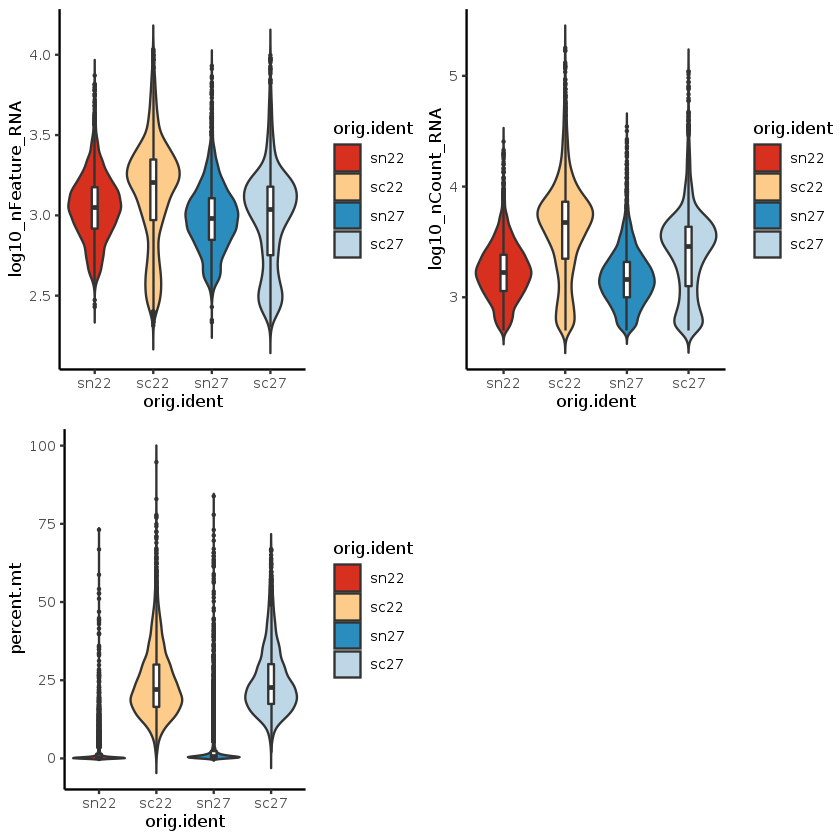

In [286]:
meta$orig.ident <- factor(meta$orig.ident, levels = c("sn22","sc22","sn27","sc27"))

nfeat <- ggplot(meta, aes(x=orig.ident, y=log10_nFeature_RNA, fill=orig.ident)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#fdcc8a","#2b8cbe","#bdd7e7"))

ncount <- ggplot(meta, aes(x=orig.ident, y=log10_nCount_RNA, fill=orig.ident)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#fdcc8a","#2b8cbe","#bdd7e7"))

pct.mt <- ggplot(meta, aes(x=orig.ident, y=percent.mt, fill=orig.ident)) + 
  geom_violin(trim=FALSE, scale = 'width')+
  geom_boxplot(width=0.1, fill="white", outlier.size = 0.2) + theme_classic() + theme(text = element_text(size = 10)) + scale_fill_manual(values = c("#d7301f","#fdcc8a","#2b8cbe","#bdd7e7"))

ggarrange(nfeat, ncount, pct.mt, nrow = 2, ncol = 2)

## Standard processing workflow for snRNA-Seq sample
Parameters for cell filtering, normalization, feature selection, dimension reduction, and clustering of snRNA-Seq data can be identical to those for scRNA-Seq data. 

Centering and scaling data matrix
PC_ 1 
Positive:  SLC8A1, EPHA3, ITGA1, HDAC9, SPARCL1, SYNE1, SPOCK3, IGFBP7, EYA1, EYA4 
	   COL6A3, CARMN, SOX5, LSAMP, ATRNL1, LDB2, THSD7A, PDZRN4, COL4A1, COL4A2 
	   TRHDE, AC131025.2, GSN, SLC8A1-AS1, LAMA2, LRFN5, UNC5C, CPED1, GLIS1, COL1A2 
Negative:  CPA6, EHF, MPPED2, TTC6, NEDD4L, RBM47, HIST1H2AC, SLC14A1, CADM1, ARHGEF38 
	   KANK1, MIR205HG, MECOM, ERVMER61-1, C15orf53, TMPRSS2, MIR2052HG, ITPR2, ESRRG, WNT5B 
	   GRIK2, AC023421.2, AC108861.1.1, ATP2C2, LYPD6B, KIAA1324, ARFGEF3, ATP8A1, LINC01876, AQP4-AS1 
PC_ 2 
Positive:  FLT1, ADGRL4, VWF, PTPRB, CYYR1, EGFL7, AQP1, IFI27, ENPP2, ST6GALNAC3 
	   CD93, EMCN, ABCG2, CLDN5, CALCRL, AC074286.1, ANO2, PLVAP, CD74, ABCB1 
	   STC1, NOSTRIN, CLEC1A, MCTP1, DIPK2B, FLI1, AC010737.1, SEC14L1, EPAS1, LIFR 
Negative:  EPHA3, LSAMP, EYA1, MIR99AHG, SPOCK3, EYA4, LAMA2, ATRNL1, COL6A3, TRHDE 
	   CNTN1, MEIS1, PDZRN3, LRFN5, UNC5C, PDZRN4, GLIS1, CACNA1C, CARMN, BMP5 
	   ADAMTS9-AS2, SLC8A1,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4375
Number of edges: 155248

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9689
Number of communities: 7
Elapsed time: 0 seconds


23:08:39 UMAP embedding parameters a = 0.9922 b = 1.112
23:08:39 Read 4375 rows and found 30 numeric columns
23:08:39 Using Annoy for neighbor search, n_neighbors = 30
23:08:39 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
23:08:41 Writing NN index file to temp file /tmp/21609558.1.interactive/RtmpcAAFNq/file1c7b7b085946
23:08:41 Searching Annoy index using 1 thread, search_k = 3000
23:08:42 Annoy recall = 100%
23:08:43 Commencing smooth kNN distance calibration using 1 thread
23:08:44 Initializing from normalized Laplacian + noise
23:08:45 Commencing optimization for 500 epochs, with 179322 positive edges
23:09:02 Optimization finished


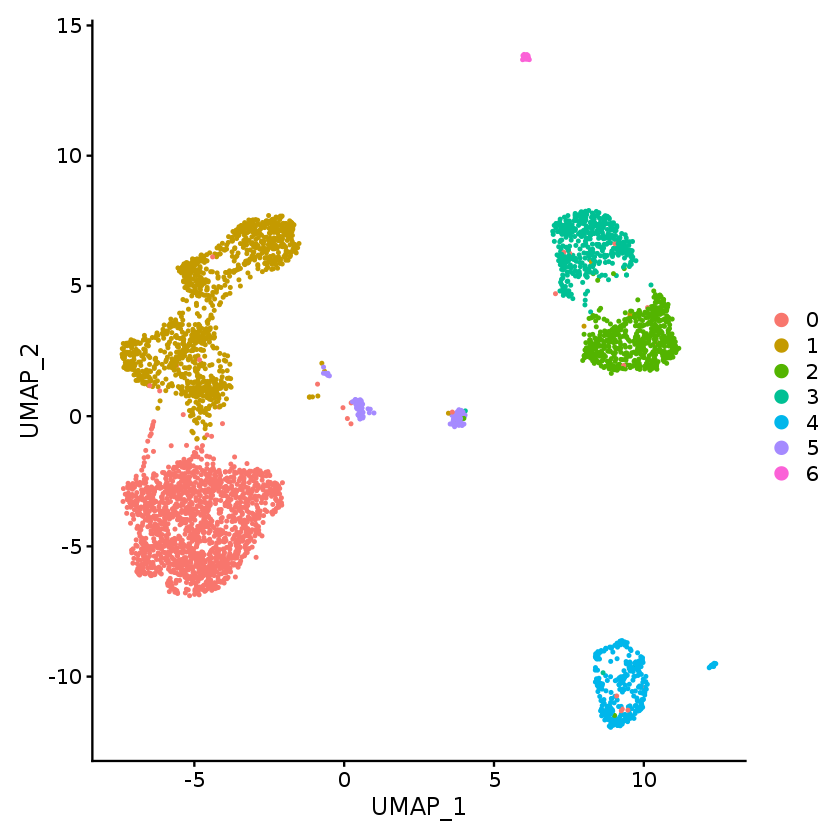

In [287]:
#Retain cells with a percent mitochondrial fraction < 25% 
seur_sn22 <- subset(seur_sn22, subset = nFeature_RNA > 200 & percent.mt < 25)

#Standard Seurat library size normalization
seur_sn22 <- NormalizeData(seur_sn22)

#Select variable features - for individual samples, 5000 features is usually more than adequate 
#to capture all biologically significant variability
seur_sn22 <- FindVariableFeatures(seur_sn22, selection.method = "vst", nfeatures = 5000)

#Z-normalize/scale data, then run PCA using only variable features
all.genes <- rownames(seur_sn22)
seur_sn22 <- ScaleData(seur_sn22, features = all.genes)
seur_sn22 <- RunPCA(seur_sn22, features = VariableFeatures(object = seur_sn22), npcs = 60)

#Perform unsupervised clustering in PCA space, using only the dimensions which will also be used for UMAP
seur_sn22 <- FindNeighbors(seur_sn22, dims = 1:30)
seur_sn22 <- FindClusters(seur_sn22, resolution = 0.1)

#Perform UMAP on principal components and plot
seur_sn22 <- RunUMAP(seur_sn22, dims = 1:30)
DimPlot(seur_sn22)

Clustering resolution can be manually tuned to better correspond with spatially resolved groupings in UMAP space.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4375
Number of edges: 155248

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9295
Number of communities: 8
Elapsed time: 0 seconds


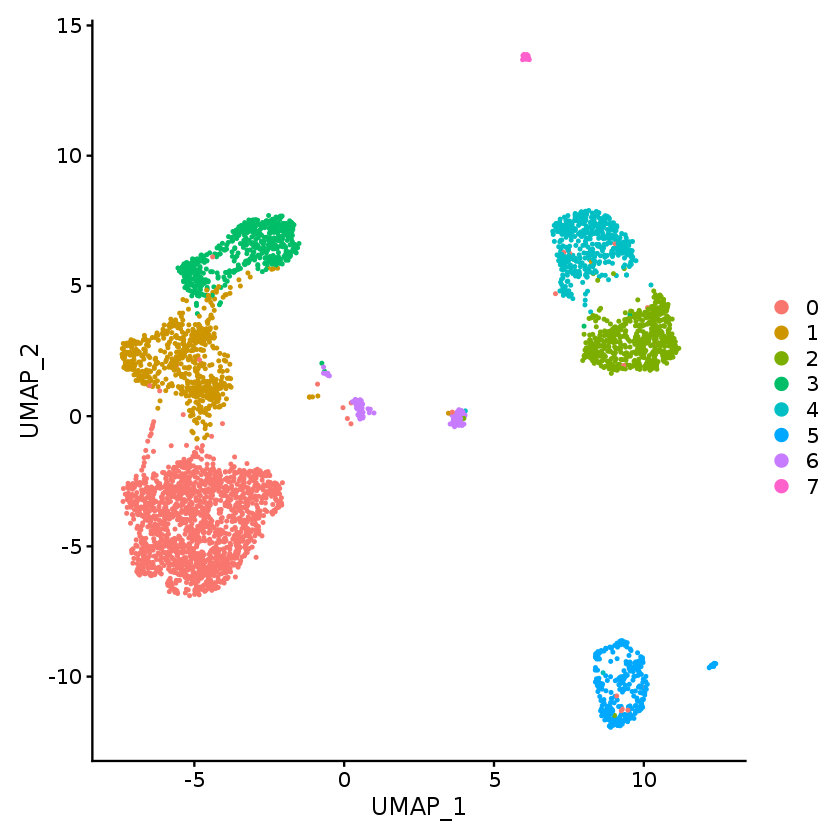

In [288]:
seur_sn22 <- FindClusters(seur_sn22, resolution = 0.3)
DimPlot(seur_sn22)

Now we perform Wilcoxon differential expression between cells of each cluster and cells of all other clusters to identify cluster-specific markers for cell type annotation.

In [289]:
#Perform Wilcoxon DE
seur_sn22.markers <- FindAllMarkers(seur_sn22, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

#View top genes for each cluster
seur_sn22.markers %>% group_by(cluster) %>% top_n(n = 4, wt = avg_logFC)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7


p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.000000e+00,2.259829,0.806,0.096,0.000000e+00,0,MIR205HG
1.132773e-289,1.615683,0.720,0.215,2.966505e-285,0,SLC14A1
7.692711e-259,1.767118,0.592,0.127,2.014567e-254,0,AC023421.2
3.528404e-248,1.593784,0.433,0.033,9.240184e-244,0,TP63
9.972442e-271,1.842387,0.401,0.015,2.611583e-266,1,MMP7
1.395261e-203,1.483854,0.710,0.187,3.653908e-199,1,ZFP36L1
1.263521e-196,1.590319,0.408,0.040,3.308910e-192,1,CFTR
4.467080e-162,1.861739,0.545,0.121,1.169839e-157,1,SLC4A4
0.000000e+00,2.669508,0.719,0.038,0.000000e+00,2,C7


Plot heatmap of top genes for each cluster, downsampling each cluster to 100 cells so that smaller clusters are not obscured.

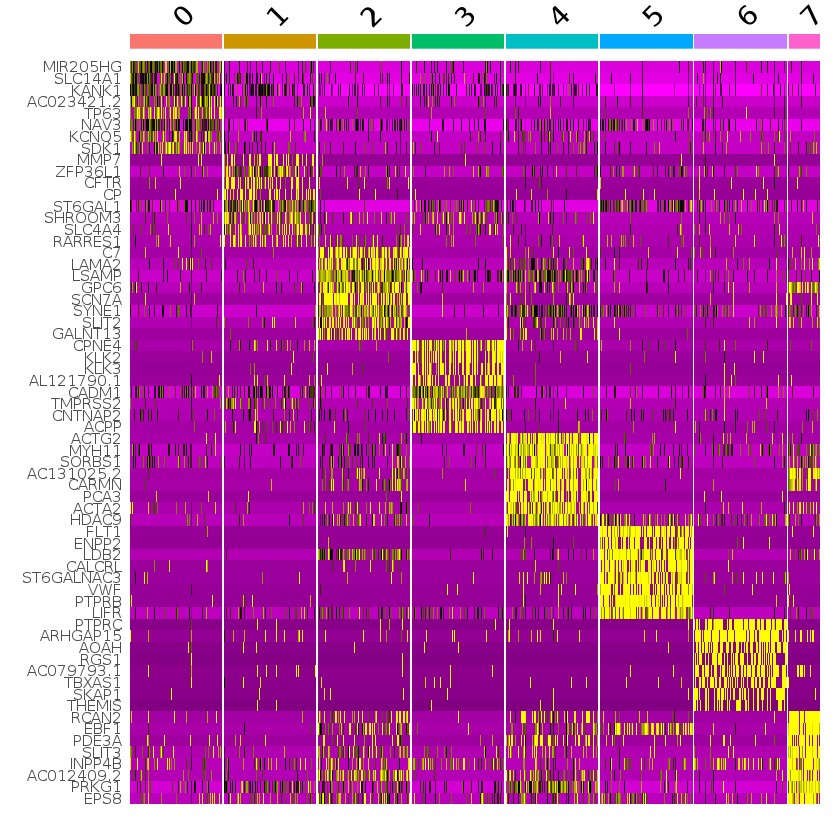

In [290]:
top8 <- seur_sn22.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_logFC)
DoHeatmap(subset(seur_sn22, downsample = 100), features = top8$gene) + NoLegend()

FeaturePlot to visualize canonical cell type specific genes and DE-identified cluster markers.

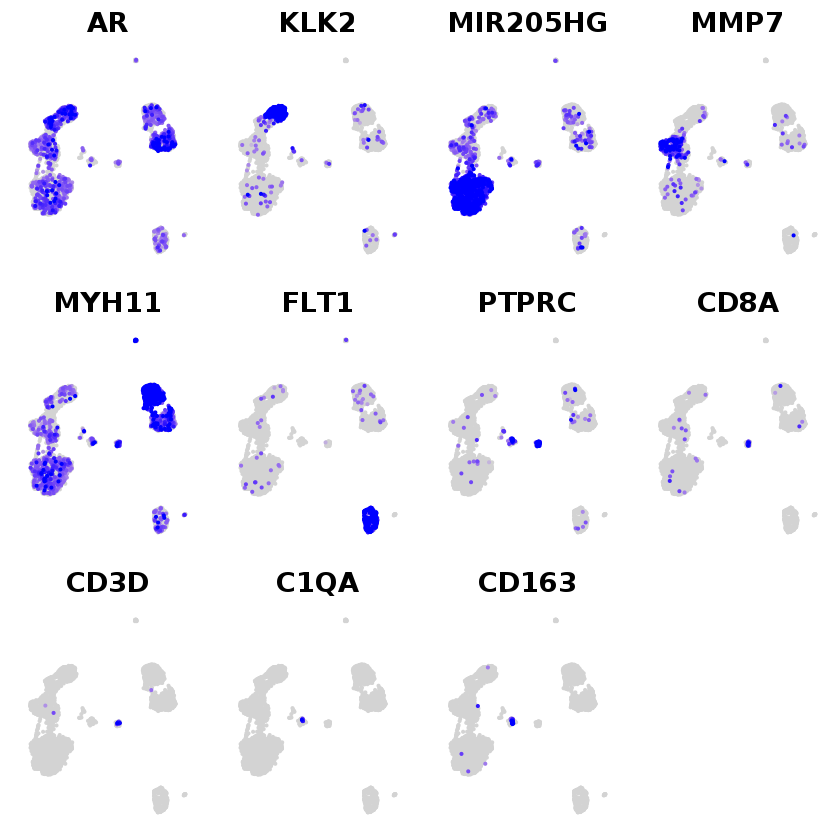

In [291]:
p <- FeaturePlot(seur_sn22, c("AR","KLK2","MIR205HG","MMP7","MYH11","FLT1","PTPRC","CD8A","CD3D","C1QA","CD163"), pt.size = 0.1, min.cutoff = 0, max.cutoff = 3, combine = F, order =T)

for(i in 1:length(p)) {
  p[[i]] <- p[[i]] + NoLegend() + NoAxes()
}

cowplot::plot_grid(plotlist = p)

Based on prior knowledge of markers for epithelial, stromal, and immune cell types in the primary PCa microenvironment, we can assign a cell type to each unsupervised cluster and update the working identity in the Seurat object.

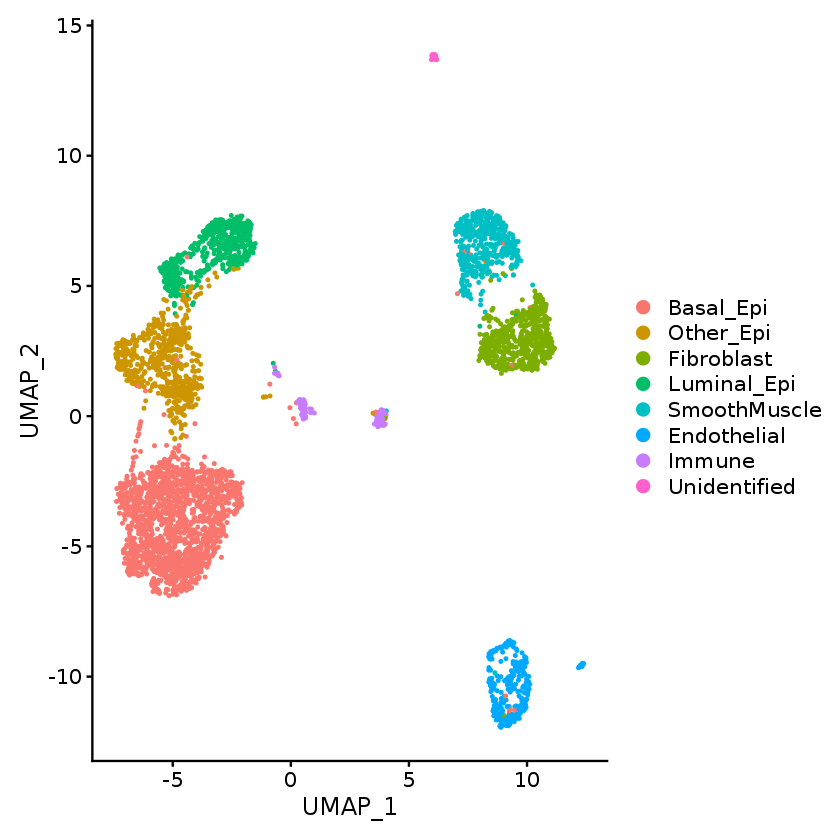

In [292]:
seur_sn22 <- RenameIdents(seur_sn22, '0' = 'Basal_Epi','1' = 'Other_Epi','2' = 'Fibroblast','3'='Luminal_Epi','4'='SmoothMuscle','5'='Endothelial','6' = 'Immune','7' = 'Unidentified')
DimPlot(seur_sn22)

In some cases, further subsetting of an object will be necessary to fully resolve cell types by cluster in projection space. In this instance, the cluster annotated as Immune (broadly expressing PTPRC) seems to comprise two spatially resolved groupings, one of which appears lymphoid (CD8A, CD3D), and the other myeloid (C1QA, CD163). We can subset the current Seurat object to cluster 6 and perform feature selection, dimension reduction, and clustering to cells from this cluster to resolve their phenotypes at a higher resolution. These refined mappings can then be superimposed upon the original, full Seurat object.

Centering and scaling data matrix
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.2043"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.32064"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.2019e-29"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.090619"PC_ 1 
Positive:  PARD3, ENAH, KIAA1217, PTPRK, TSHZ2, CADPS2, IGSF1, AC104123.1, SHROOM3, THSD4 
	   GALNT18, MRTFB, TTC6, KANK1, NAALADL2, GLI3, MECOM, NFIB, LIMCH1, OBSCN 
	   PTK2, RBPMS, NOS1AP, MAGI1, SEMA5A, RBFOX2, SEMA3C, MXI1, CYP7B1, ROR2 
Negative:  CD247, ETS1, AC016074.2, CAMK4, THEMIS, OPRM1, ITK, LINC01619, KLRD1, LINC01934 
	   ARAP2, CEMIP2, PHTF2, TXK, PSMB9, ITGAE, BFSP2, CD69, BCL2L11, AC090627.1 
	   AL137025.1, ADAM19, GNLY,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 153
Number of edges: 5703

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9169
Number of communities: 2
Elapsed time: 0 seconds


23:09:59 UMAP embedding parameters a = 0.9922 b = 1.112
23:09:59 Read 153 rows and found 30 numeric columns
23:09:59 Using Annoy for neighbor search, n_neighbors = 30
23:09:59 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
23:09:59 Writing NN index file to temp file /tmp/21609558.1.interactive/RtmpcAAFNq/file1c7b6477dc38
23:09:59 Searching Annoy index using 1 thread, search_k = 3000
23:09:59 Annoy recall = 100%
23:10:00 Commencing smooth kNN distance calibration using 1 thread
23:10:01 Initializing from normalized Laplacian + noise
23:10:01 Commencing optimization for 500 epochs, with 6070 positive edges
23:10:02 Optimization finished


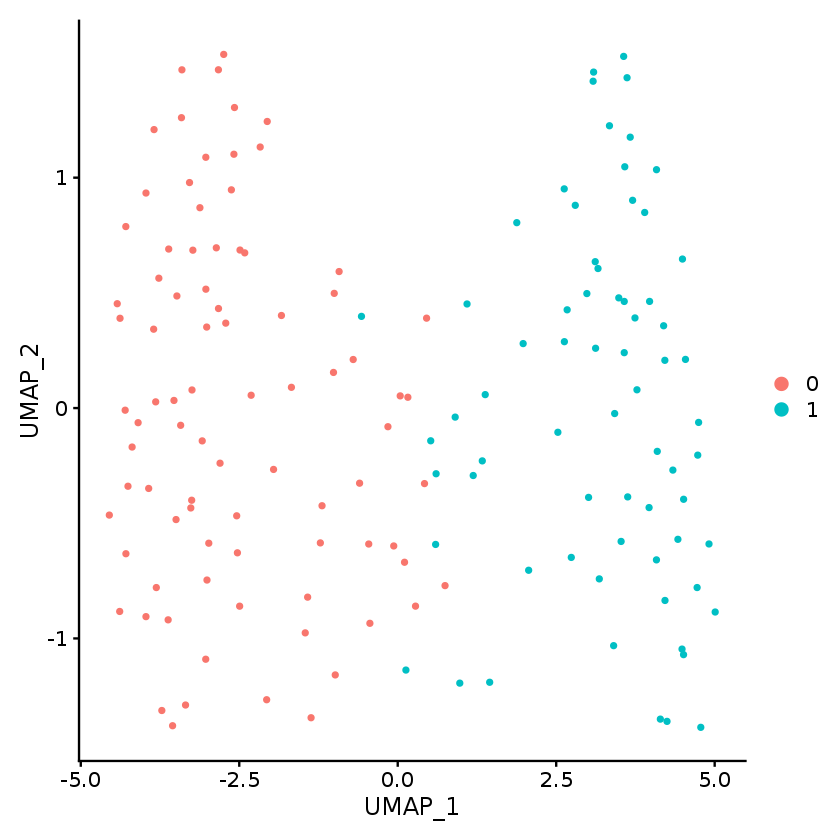

In [293]:
#Here, we subset to the Immune cluster, re-scale, re-identify variable features, then perform 
#dimension reduction and clustering only on this subset of cells. 
sn22_Immune <- subset(seur_sn22, idents = "Immune")
all.genes <- rownames(sn22_Immune)
sn22_Immune <- ScaleData(sn22_Immune, features = all.genes)
sn22_Immune <- FindVariableFeatures(sn22_Immune, selection.method = "vst")
top10 <- head(VariableFeatures(sn22_Immune), 10)
sn22_Immune <- RunPCA(sn22_Immune, features = VariableFeatures(object = sn22_Immune), npcs = 60)
sn22_Immune <- FindNeighbors(sn22_Immune, dims = 1:30)
sn22_Immune <- FindClusters(sn22_Immune, resolution = 0.1)
sn22_Immune <- RunUMAP(sn22_Immune, dims = 1:30)
DimPlot(sn22_Immune)

Two distinct clusters emerge. We then perform differential expression between these two clusters to assign cell type. 

In [294]:
cluster0_vs_cluster1 <- FindAllMarkers(sn22_Immune, only.pos = TRUE, min.pct = 0, logfc.threshold = 0)

Calculating cluster 0
Calculating cluster 1


We can then inspect the DE genes for cluster 0 and cluster 1.

In [295]:
subset(cluster0_vs_cluster1, cluster == 0 & p_val_adj < 0.01 & avg_logFC > 2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
FYN,4.269561e-19,2.686435,0.788,0.044,1.118113e-14,0,FYN
SKAP1,7.460972e-18,2.693693,0.753,0.044,1.953879e-13,0,SKAP1
ETS1,7.336924e-15,2.458024,0.635,0.015,1.921394e-10,0,ETS1
TOX,9.763162e-13,2.386266,0.624,0.074,2.556777e-08,0,TOX
THEMIS,1.017576e-11,2.831344,0.541,0.029,2.664829e-07,0,THEMIS
BCL11B,3.957325e-11,2.081846,0.506,0.015,1.036344e-06,0,BCL11B
CD247,2.074494e-10,2.182640,0.459,0.000,5.432685e-06,0,CD247
LINC01934,4.467778e-10,2.269653,0.482,0.029,1.170022e-05,0,LINC01934
CD69,8.745352e-09,2.035747,0.424,0.015,2.290233e-04,0,CD69


In [296]:
subset(cluster0_vs_cluster1, cluster == 1 & p_val_adj < 0.01 & avg_logFC > 2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
PLXDC2,2.526067e-25,2.802237,0.956,0.212,6.615264e-21,1,PLXDC2
SLC8A1,4.248870e-25,2.940823,0.912,0.071,1.112694e-20,1,SLC8A1
LRMDA,3.361073e-23,2.187320,0.971,0.200,8.801979e-19,1,LRMDA
DOCK4,5.699251e-23,2.646383,0.882,0.094,1.492520e-18,1,DOCK4
SRGAP1,4.450367e-22,3.017267,0.824,0.059,1.165462e-17,1,SRGAP1
FRMD4A,1.849469e-21,2.589963,0.897,0.212,4.843389e-17,1,FRMD4A
SRGAP2B,4.611874e-21,2.052396,0.941,0.235,1.207757e-16,1,SRGAP2B
SLC1A3,5.637331e-20,2.493443,0.750,0.024,1.476304e-15,1,SLC1A3
FMN1,4.158457e-19,2.697789,0.735,0.035,1.089017e-14,1,FMN1


Cluster 0 is enriched for lymphoid-associated genes TOX, CD69, and CD247. Cluster 1 is enriched for myeloid-associated genes CD163, HLA-DRA, MS4A6A. We therefore extract the barcodes for Cluster 0 (Lymphoid) and Cluster 1 (Myeloid) cells, and rename these cells in the original Seurat object accordingly.

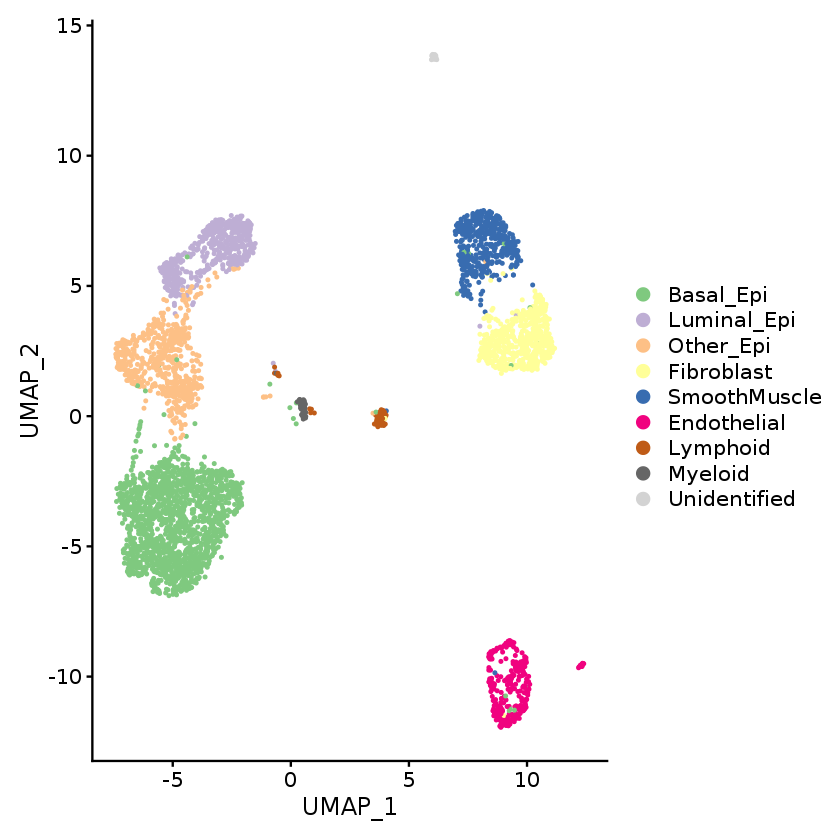

In [297]:
#Extract barcodes
lymphoid <- row.names(subset(sn22_Immune@meta.data, seurat_clusters == 0))
myeloid <- row.names(subset(sn22_Immune@meta.data, seurat_clusters == 1))

#Set identities in original seurat object
seur_sn22 <- SetIdent(seur_sn22, cells = lymphoid, value = "Lymphoid")
seur_sn22 <- SetIdent(seur_sn22, cells = myeloid, value = "Myeloid")

#Reorder identities and plot UMAP
Idents(seur_sn22) <- factor(Idents(seur_sn22), levels = c("Basal_Epi","Luminal_Epi","Other_Epi","Fibroblast","SmoothMuscle","Endothelial","Lymphoid","Myeloid","Unidentified"))
DimPlot(seur_sn22, cols = c(brewer.pal(8, "Accent"),"lightgrey"))

Re-calculate differentially expressed genes and plot heatmap

Calculating cluster Basal_Epi
Calculating cluster Luminal_Epi
Calculating cluster Other_Epi
Calculating cluster Fibroblast
Calculating cluster SmoothMuscle
Calculating cluster Endothelial
Calculating cluster Lymphoid
Calculating cluster Myeloid
Calculating cluster Unidentified


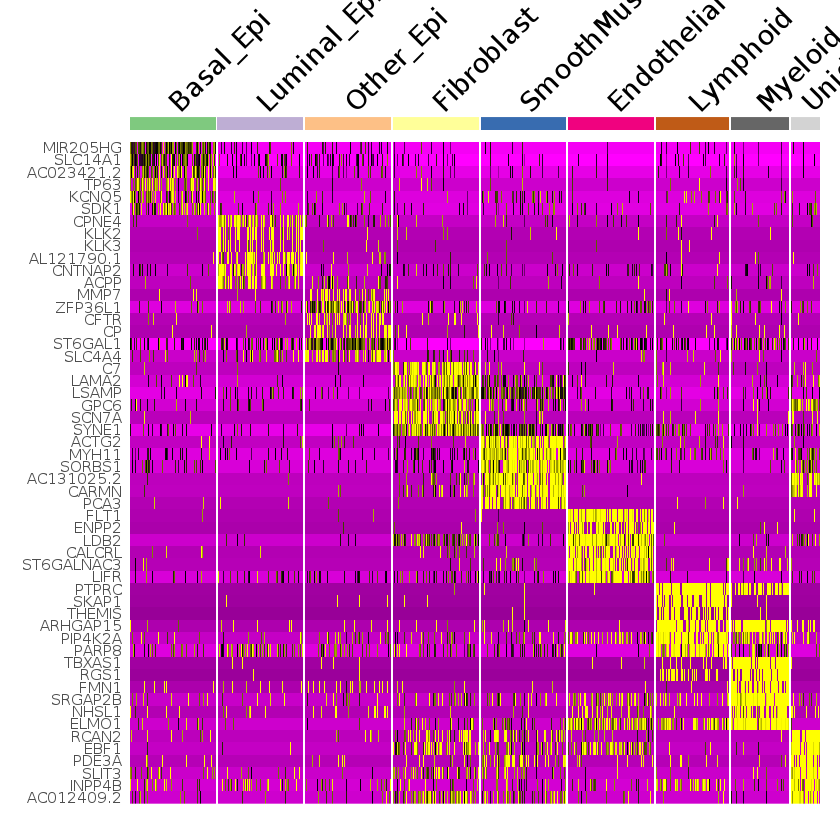

In [298]:
seur_sn22.markers <- FindAllMarkers(seur_sn22, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
top6 <- seur_sn22.markers %>% group_by(cluster) %>% top_n(n = 6, wt = avg_logFC)
DoHeatmap(subset(seur_sn22, downsample = 100),group.colors = c(brewer.pal(8, "Accent"),"lightgrey"), features = top6$gene) + NoLegend()

### Visualize Scrublet-inferred doublets in projection space

Read in output from Scrublet, annotating each barcode as an inferred doublet or singlet.

In [299]:
scrublet_sn22 <- read.csv("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/P22_T1_scrublet_output_table.csv",header=T, check.names = F)
row.names(scrublet_sn22) <- colnames(sn22)
scrublet_sn22$barcode <- row.names(scrublet_sn22)

Add Scrublet result to meta.data slot of Seurat object and color UMAP by True/False for inferred doublet.

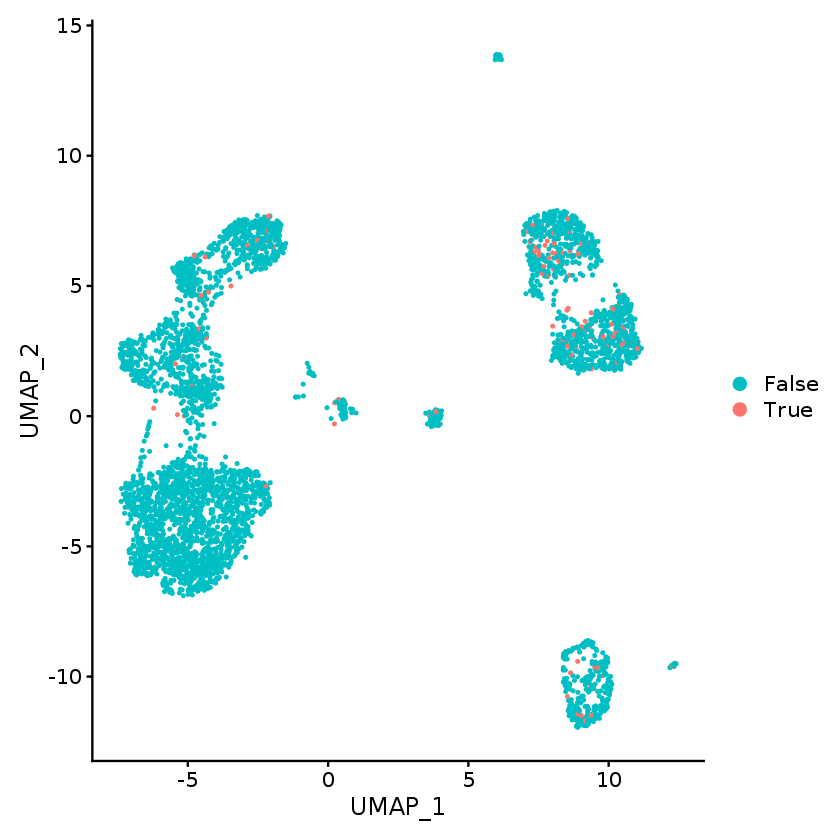

In [300]:
sn22_meta <- seur_sn22@meta.data
sn22_meta$barcode <- row.names(sn22_meta)

new_meta <- left_join(sn22_meta, scrublet_sn22, by = "barcode")
row.names(new_meta) <- row.names(sn22_meta)
seur_sn22@meta.data <- new_meta
DimPlot(seur_sn22, group.by = "predicted_doublet", cols = c("#00BFC4","#F8766D"))

Save fully processed and annotated object.

In [301]:
saveRDS(seur_sn22,"/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/seur_sn22.RDS")

### Comparison of cell type proportions between snRNA-Seq and scRNA-Seq
scRNA-Seq data for P22, as well as snRNA-Seq and scRNA-Seq for P27 were processed and annotated as described above. Here, we import fully processed Seurat objects for these samples to compare snRNA-Seq and scRNA-Seq data for matched specimens.

In [302]:
seur_sc22 <- readRDS(file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/seur_sc22.RDS")
seur_sn27 <- readRDS(file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/seur_sn27.RDS")
seur_sc27 <- readRDS(file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/POS/seur_sc27.RDS")

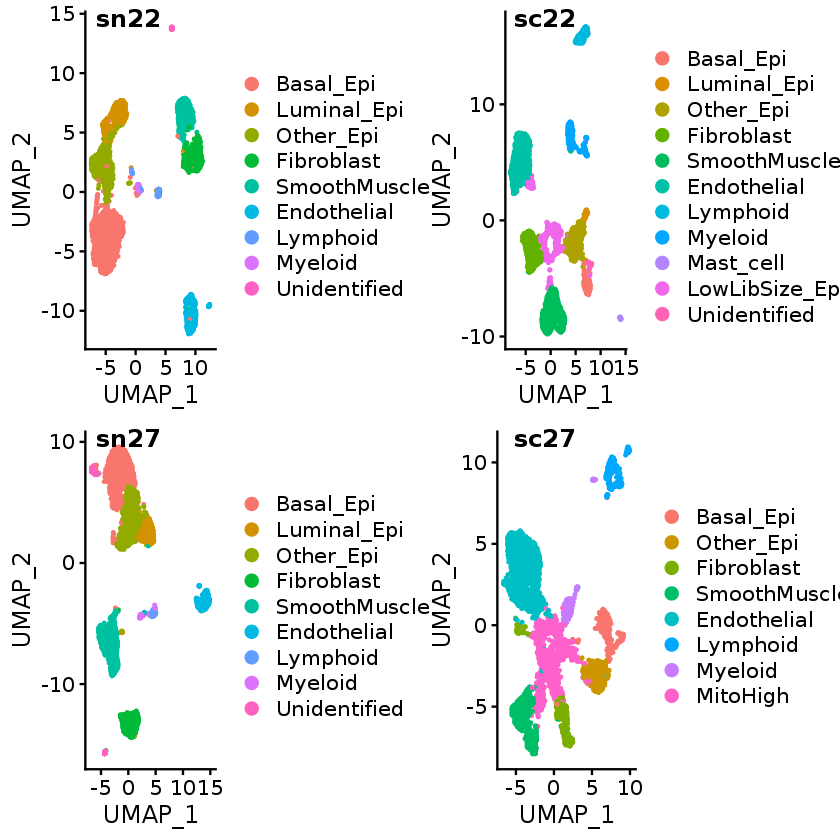

In [303]:
ggarrange(DimPlot(seur_sn22), DimPlot(seur_sc22), DimPlot(seur_sn27),DimPlot(seur_sc27), nrow = 2, ncol = 2, labels = c("sn22",'sc22','sn27','sc27'), label.x = 0.15)

### Calculate cell type proportions and plot bar graphs

Merge all four Seurat objects and remove superfluous populations (low library size, mito-high, unidentified). Then calculate cell type proportions.

In [304]:
seur_all <- merge(seur_sn22, y = c(seur_sc22, seur_sn27, seur_sc27), add.cell.ids = c("sn22","sc22", "sn27", "sc27"))
seur_all <- subset(seur_all, idents = c("LowLibSize_Epi","MitoHigh","Unidentified"), invert = T)

Calculate proportions and order factors.

In [305]:
props <- prop.table(table(Idents(seur_all),seur_all$orig.ident), margin = 2)
props <- data.frame(props)
props$Var1 <- factor(props$Var1, levels = c("Basal_Epi","Luminal_Epi","Other_Epi","Fibroblast","SmoothMuscle","Endothelial","Lymphoid","Myeloid","Mast_cell","Unidentified"))
props$Var2 <- factor(props$Var2, levels = c("sn22","sc22","sn27","sc27"))
corner(props)

Var1,Var2,Freq
<fct>,<fct>,<dbl>
Basal_Epi,sc22,0.05392157
Endothelial,sc22,0.27614379
Fibroblast,sc22,0.15882353
Luminal_Epi,sc22,0.01503268
Lymphoid,sc22,0.05000000


Plot cell type proportions within samples in stacked bar plots.

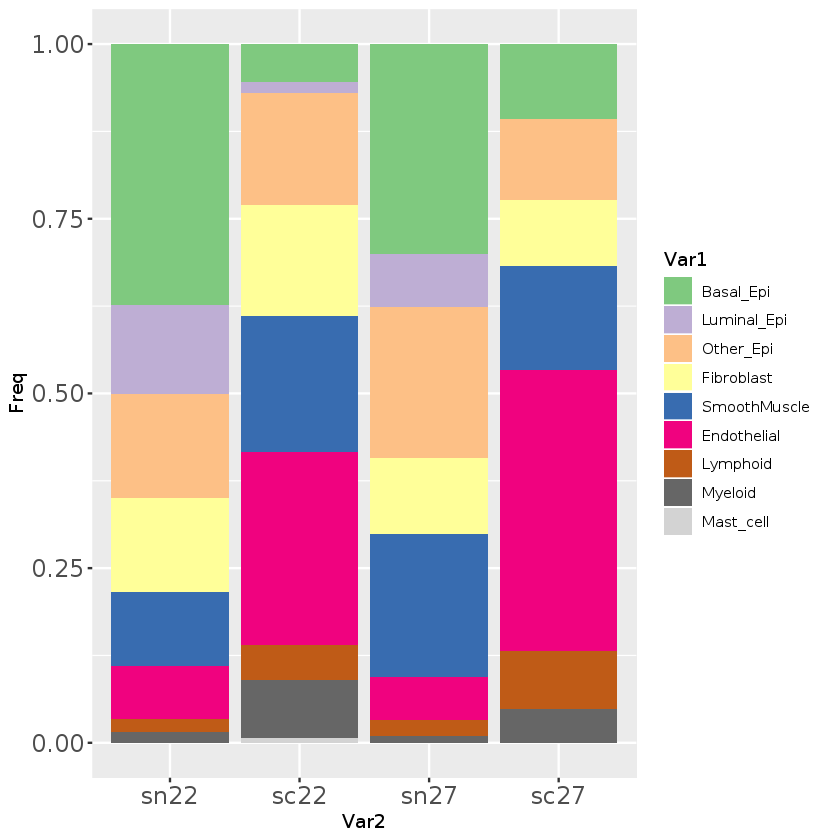

In [306]:
ggplot() + geom_bar(aes(y = Freq, x = Var2, fill = Var1), data = props, stat="identity") + theme(axis.text.x = element_text(size=14),
          axis.text.y = element_text(size=14)) + scale_fill_manual(values = c(brewer.pal(8, "Accent"),"lightgrey"))

### Quantify retrieval of cell type markers from scRNA-Seq in corresponding snRNA-Seq runs
Given that snRNA-Seq libraries comprise a set of transcripts distinct from those captured in whole-cell scRNA-Seq, including a large proportion of pre-mRNAs, it is of interest to determine the extent to which snRNA-Seq recapitulates cell-type specific transcriptional profiles identified via scRNA-Seq. Here, we quantify the percentage of whole-cell derived markers retrieved in differential expression analysis of matched single nuclei experiments.

Remove superfluous populations (low library size, mito-high, unidentified) from all Seurat objects and re-calculate differentially expressed genes.

In [307]:
seur_sn22 <- subset(seur_sn22, idents = c("Unidentified"), invert = T)
seur_sc22 <- subset(seur_sc22, idents = c("LowLibSize_Epi","Unidentified"), invert = T)
seur_sn27 <- subset(seur_sn27, idents = c("Unidentified"), invert = T)
seur_sc27 <- subset(seur_sc27, idents = c("MitoHigh"), invert = T)

seur_sn22.markers <- FindAllMarkers(seur_sn22, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
seur_sc22.markers <- FindAllMarkers(seur_sc22, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
seur_sn27.markers <- FindAllMarkers(seur_sn27, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
seur_sc27.markers <- FindAllMarkers(seur_sc27, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster Basal_Epi
Calculating cluster Luminal_Epi
Calculating cluster Other_Epi
Calculating cluster Fibroblast
Calculating cluster SmoothMuscle
Calculating cluster Endothelial
Calculating cluster Lymphoid
Calculating cluster Myeloid
Calculating cluster Basal_Epi
Calculating cluster Luminal_Epi
Calculating cluster Other_Epi
Calculating cluster Fibroblast
Calculating cluster SmoothMuscle
Calculating cluster Endothelial
Calculating cluster Lymphoid
Calculating cluster Myeloid
Calculating cluster Mast_cell
Calculating cluster Basal_Epi
Calculating cluster Luminal_Epi
Calculating cluster Other_Epi
Calculating cluster Fibroblast
Calculating cluster SmoothMuscle
Calculating cluster Endothelial
Calculating cluster Lymphoid
Calculating cluster Myeloid
Calculating cluster Basal_Epi
Calculating cluster Other_Epi
Calculating cluster Fibroblast
Calculating cluster SmoothMuscle
Calculating cluster Endothelial
Calculating cluster Lymphoid
Calculating cluster Myeloid


Identify populations shared between single nuclei and single cell runs.

In [308]:
p22_shared_celltypes <- intersect(unique(Idents(seur_sn22)), unique(Idents(seur_sc22)))
p27_shared_celltypes <- intersect(unique(Idents(seur_sn27)), unique(Idents(seur_sc27)))

For each patient, calculate percentage of scRNA-Seq derived markers retrieved by snRNA-Seq in each cell type and store as data frame, then merge.

In [309]:
p22_marker_retrieval_pct <- vector(length = length(p22_shared_celltypes))
names(p22_marker_retrieval_pct) <- intersect(unique(Idents(seur_sn22)), unique(Idents(seur_sc22)))
for (i in 1:length(p22_shared_celltypes)) {
nuc <- row.names(subset(seur_sn22.markers, p_val_adj < 0.01 & avg_logFC > 0.25 & cluster %in% p22_shared_celltypes[i]))
cell <- row.names(subset(seur_sc22.markers, p_val_adj < 0.01 & avg_logFC > 0.25 & cluster %in% p22_shared_celltypes[i]))
p22_marker_retrieval_pct[i] <- length(intersect(nuc, cell))/length(cell)
}
p22_marker_retrieval_pct <- data.frame(p22_marker_retrieval_pct)

In [310]:
p27_marker_retrieval_pct <- vector(length = length(p27_shared_celltypes))
names(p27_marker_retrieval_pct) <- intersect(unique(Idents(seur_sn27)), unique(Idents(seur_sc27)))
for (i in 1:length(p27_shared_celltypes)) {
nuc <- row.names(subset(seur_sn27.markers, p_val_adj < 0.01 & avg_logFC > 0.25 & cluster %in% p27_shared_celltypes[i]))
cell <- row.names(subset(seur_sc27.markers, p_val_adj < 0.01 & avg_logFC > 0.25 & cluster %in% p27_shared_celltypes[i]))
p27_marker_retrieval_pct[i] <- length(intersect(nuc, cell))/length(cell)
}
p27_marker_retrieval_pct <- data.frame(p27_marker_retrieval_pct)

In [311]:
marker_retrieval <- merge(p22_marker_retrieval_pct, p27_marker_retrieval_pct, by=0, all=TRUE)
marker_retrieval[is.na(marker_retrieval)] <- 0 
colnames(marker_retrieval) <- c("celltype","P22","P27")
marker_retrieval_melted <- melt(marker_retrieval)
marker_retrieval_melted$celltype <- factor(marker_retrieval_melted$celltype, levels = c("Basal_Epi","Luminal_Epi","Other_Epi","Fibroblast","SmoothMuscle","Endothelial","Lymphoid","Myeloid"))
corner(marker_retrieval_melted)

Using celltype as id variables


celltype,variable,value
<fct>,<fct>,<dbl>
Basal_Epi,P22,0.09090909
Endothelial,P22,0.30346821
Fibroblast,P22,0.20952381
Luminal_Epi,P22,0.25177305
Lymphoid,P22,0.16606498


Plot percentage marker retrieval with grouped bar plots.

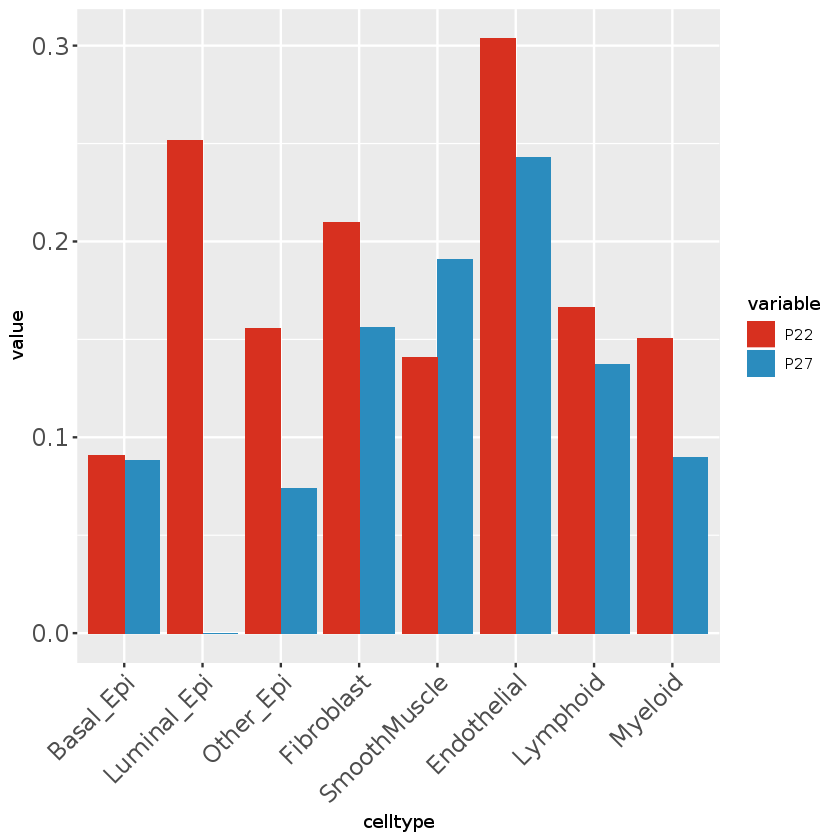

In [312]:
ggplot(marker_retrieval_melted, aes(fill=variable, y=value, x=celltype)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = c("#d7301f","#2b8cbe")) + theme(axis.text.x = element_text(size=14, angle = 45, hjust = 1),
          axis.text.y = element_text(size=14))